In [1]:
%cd C:\MINE\NCKH\chat2edit-framework\mic2e-api

C:\MINE\NCKH\chat2edit-framework\mic2e-api


In [2]:
import torch
from PIL import Image
from torchvision import transforms
import numpy as np
from core.inference.predictors.impl.model_enhancement_predictor import ModelEnhancingPredictor

In [3]:
enhanment_model_path =r'C:\MINE\NCKH\chat2edit-framework\mic2e-api\resources\weights\epoch_25.pth'
image_path = r'C:\MINE\NCKH\chat2edit-framework\mic2e-api\resources\images\pic27.jpg'

In [4]:
predictor = ModelEnhancingPredictor(checkpoint_path=enhanment_model_path)
predictor.load()
image = Image.open(image_path).convert("RGB")
res = predictor.predict_enhancement(image)
print(res)

Initializing resnet18 model...


c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Number of trainable parameters: 11689512
{'saturation': -25.815309524536133, 'brightness': 29.17211151123047, 'tint': 5.118223190307617, 'temperature': 1.540175437927246, 'contrast': -0.01340336725115776}


In [4]:
def load_trained_model(weight_path, device, n_factors=5, activation='tanh'):
    model = AestheticRegressor(
        n_factors=n_factors,
        activation=activation,
    ).to(device)
    #load trọng số
    state_dict = torch.load(weight_path, map_location=device)
    model.load_state_dict(state_dict, strict=False)
    model.eval()
    return model

In [5]:
def predict_image_adjustments(image_path, model, device=None):

    device = device or ('cuda:0' if torch.cuda.is_available() else 'cpu')

    factors = ['saturation', 'brightness', 'tint', 'temperature', 'contrast']
    factors_coefs = {
        'saturation': 43,
        'brightness': 43,
        'tint': 30,
        'temperature': 30,
        'contrast': 43,
    }
    transform = transforms.Compose([
        transforms.Resize((640, 640)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])

    class Normalizer:
        def __init__(self, coefs):
            self.coefs = np.array(list(coefs.values()), dtype=np.float32)
        def transform(self, labels):
            return labels / self.coefs
        def inverse_transform(self, norm_labels):
            return norm_labels * self.coefs

    label_normalizer = Normalizer(factors_coefs)

    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        preds = model(image_tensor).cpu().numpy().flatten()

    preds_denorm = label_normalizer.inverse_transform(preds)
    result = {factors[i]: float(preds_denorm[i]) for i in range(len(factors))}
    return result

In [22]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

model = load_trained_model(
    weight_path=r'C:\MINE\NCKH\chat2edit-framework\image-editing\image_enhancing\model\epoch_25.pth',
    device=device
)
image_path = r'C:\MINE\NCKH\chat2edit-framework\image-editing\test_image\pic27.jpg'
results = predict_image_adjustments(image_path, model, device)

print("Kết quả dự đoán chỉnh sửa ảnh:")
for k, v in results.items():
    print(f"  {k}: {v:.2f}")


Initializing resnet18 model...
Number of trainable parameters: 11689512
Kết quả dự đoán chỉnh sửa ảnh:
  saturation: -6.80
  brightness: 4.37
  tint: -7.56
  temperature: 11.67
  contrast: -15.76


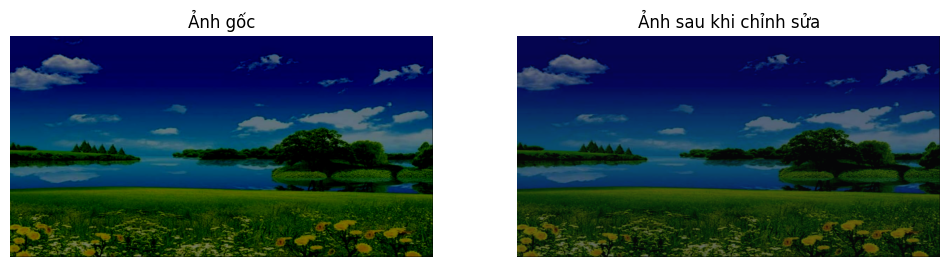

In [23]:
import cv2
import numpy as np
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt

def apply_enhancements(image_path: str, adjustments: dict):
    """
    Áp dụng các filter chỉnh sửa ảnh dựa trên giá trị dự đoán từ model.
    """
    image = Image.open(image_path).convert("RGB")

    # --- Brightness ---
    if 'brightness' in adjustments:
        enhancer = ImageEnhance.Brightness(image)
        factor = 1 + adjustments['brightness'] / 100.0  # scale 0–100 → 1.0–2.0
        image = enhancer.enhance(factor)

    # --- Contrast ---
    if 'contrast' in adjustments:
        enhancer = ImageEnhance.Contrast(image)
        factor = 1 + adjustments['contrast'] / 100.0
        image = enhancer.enhance(factor)

    # --- Saturation (Color) ---
    if 'saturation' in adjustments:
        enhancer = ImageEnhance.Color(image)
        factor = 1 + adjustments['saturation'] / 100.0
        image = enhancer.enhance(factor)

    # --- Temperature ---
    if 'temperature' in adjustments:
        temp = adjustments['temperature']
        img_np = np.array(image).astype(np.float32)
        if temp > 0:
            # làm ấm ảnh (vàng hơn)
            img_np[..., 0] *= (1 - temp / 200)  # giảm Blue
            img_np[..., 2] *= (1 + temp / 200)  # tăng Red
        else:
            # làm lạnh ảnh (xanh hơn)
            img_np[..., 0] *= (1 + abs(temp) / 200)
            img_np[..., 2] *= (1 - abs(temp) / 200)
        img_np = np.clip(img_np, 0, 255).astype(np.uint8)
        image = Image.fromarray(img_np)

    # --- Tint (điều chỉnh tông màu lục-tím) ---
    if 'tint' in adjustments:
        tint = adjustments['tint']
        img_np = np.array(image).astype(np.float32)
        img_np[..., 1] *= (1 + tint / 200)  # tăng/giảm kênh xanh lá
        img_np = np.clip(img_np, 0, 255).astype(np.uint8)
        image = Image.fromarray(img_np)

    return image


def show_before_after(image_path: str, adjusted_image: Image.Image):
    """
    Hiển thị ảnh gốc và ảnh đã chỉnh sửa song song.
    """
    original = Image.open(image_path).convert("RGB")

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Ảnh gốc")
    plt.imshow(original)
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Ảnh sau khi chỉnh sửa")
    plt.imshow(adjusted_image)
    plt.axis("off")

    plt.show()

# Áp dụng chỉnh sửa ảnh
adjusted_image = apply_enhancements(image_path, results)

# Hiển thị kết quả
show_before_after(image_path, adjusted_image)
